In [ ]:
import numpy as np
import pandas as pd

from scipy.stats import entropy

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [3]:
# Specify the path to the BindingDB dataset file
file_path = 'BindingDB_All.tsv'

# Step 1: Selective loading of columns to reduce memory usage
# Specify the columns to load
list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']
data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])
df = pd.DataFrame(data)
df.head()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_6992\2486889280.py:11: DtypeWarning: Columns (8,9,10,11,12,13,15,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,...,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#metric analysis to find which one between Ki and Kd are mostly present values in the dataset
non_nan_ki = data['Ki (nM)'].count()
print('Numbers of data containing Ki information: ', non_nan_ki)

non_nan_kd = data['Kd (nM)'].count()
print('Numbers of data containing Kd information: ', non_nan_kd)

Numbers of data containing Ki information:  591908
Numbers of data containing Kd information:  110827


We have information about Ki more than Kd in the dataset.

In [15]:
# Drop rows that contain any NaN value
df_cleaned = data.dropna(subset= ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)'], how = 'any')
df_cleaned.reset_index()
#df_cleaned.head()


,index,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444348,2913146,NOCc1ccc(cc1)S(N)(=O)=O,Carbonic anhydrase 12,Homo sapiens,5400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444349,2913147,CC(=O)Nc1nnc(s1)S(N)(=O)=O,Carbonic anhydrase 12,Homo sapiens,5.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444350,2913148,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...,Carbonic anhydrase 12,Homo sapiens,9600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444351,2913149,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...,Carbonic anhydrase 12,Homo sapiens,14000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#HIV1 targeting coumpunds
metric = 'Ki (nM)'

hiv_data = df_cleaned[df_cleaned['Target Source Organism According to Curator or DataSource'].str.contains("Human immunodeficiency virus 1", case=False, na=False)].copy()
print(f'prior size: {hiv_data.shape[0]}')

mask_invalid_values = hiv_data[metric].str.contains('<',case=False,na=False) | hiv_data[metric].str.contains('>',case=False,na=False) | hiv_data[metric].isna()
print(f'final size: {hiv_data.shape[0] - mask_invalid_values.sum()}')
hiv_data = hiv_data[~mask_invalid_values]

prior size: 4350
final size: 4171


Number of targets of the comounds in HIV1:  126


C:\Users\hudrya\AppData\Local\Temp\ipykernel_6992\4202495263.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis')


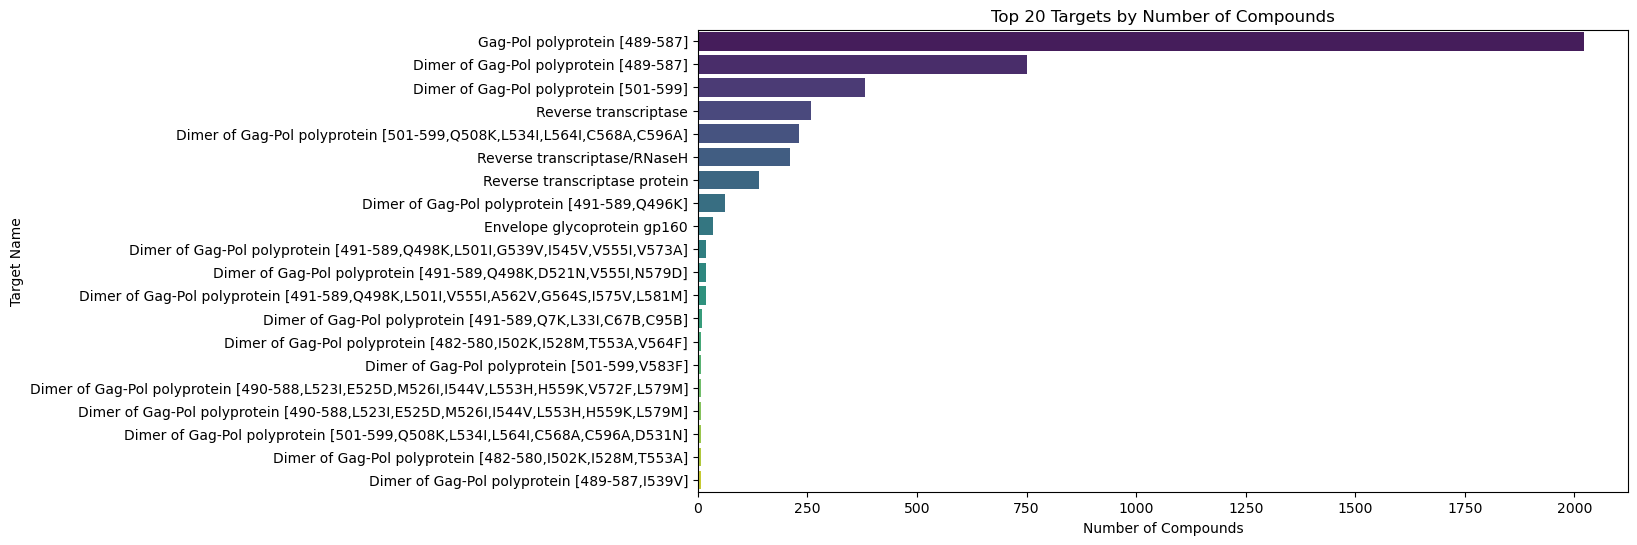

In [7]:
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

# Step 5: Sort targets by the number of compounds
target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the compounds in HIV1: ', target_counts.size)

# Step 6: Plot the distribution of targets
plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis')
plt.title('Top 20 Targets by Number of Compounds')
plt.xlabel('Number of Compounds')
plt.ylabel('Target Name')
plt.show()

In [8]:
# Step 1: Generate Morgan Fingerprints
def generate_fingerprints(smiles_list, radius=2, n_bits=1024):
    """Generates Morgan fingerprints for a list of SMILES strings using MorganGenerator."""
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)  
    fingerprints = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(None)
    
    return np.array([fp for fp in fingerprints if fp is not None])  # Remove None entries

doing radius 2
trying perplexity 5
trying perplexity 20
trying perplexity 35
trying perplexity 50
doing radius 3
trying perplexity 5
trying perplexity 20
trying perplexity 35
trying perplexity 50
doing radius 4
trying perplexity 5
trying perplexity 20
trying perplexity 35
trying perplexity 50
doing radius 5
trying perplexity 5
trying perplexity 20
trying perplexity 35
trying perplexity 50


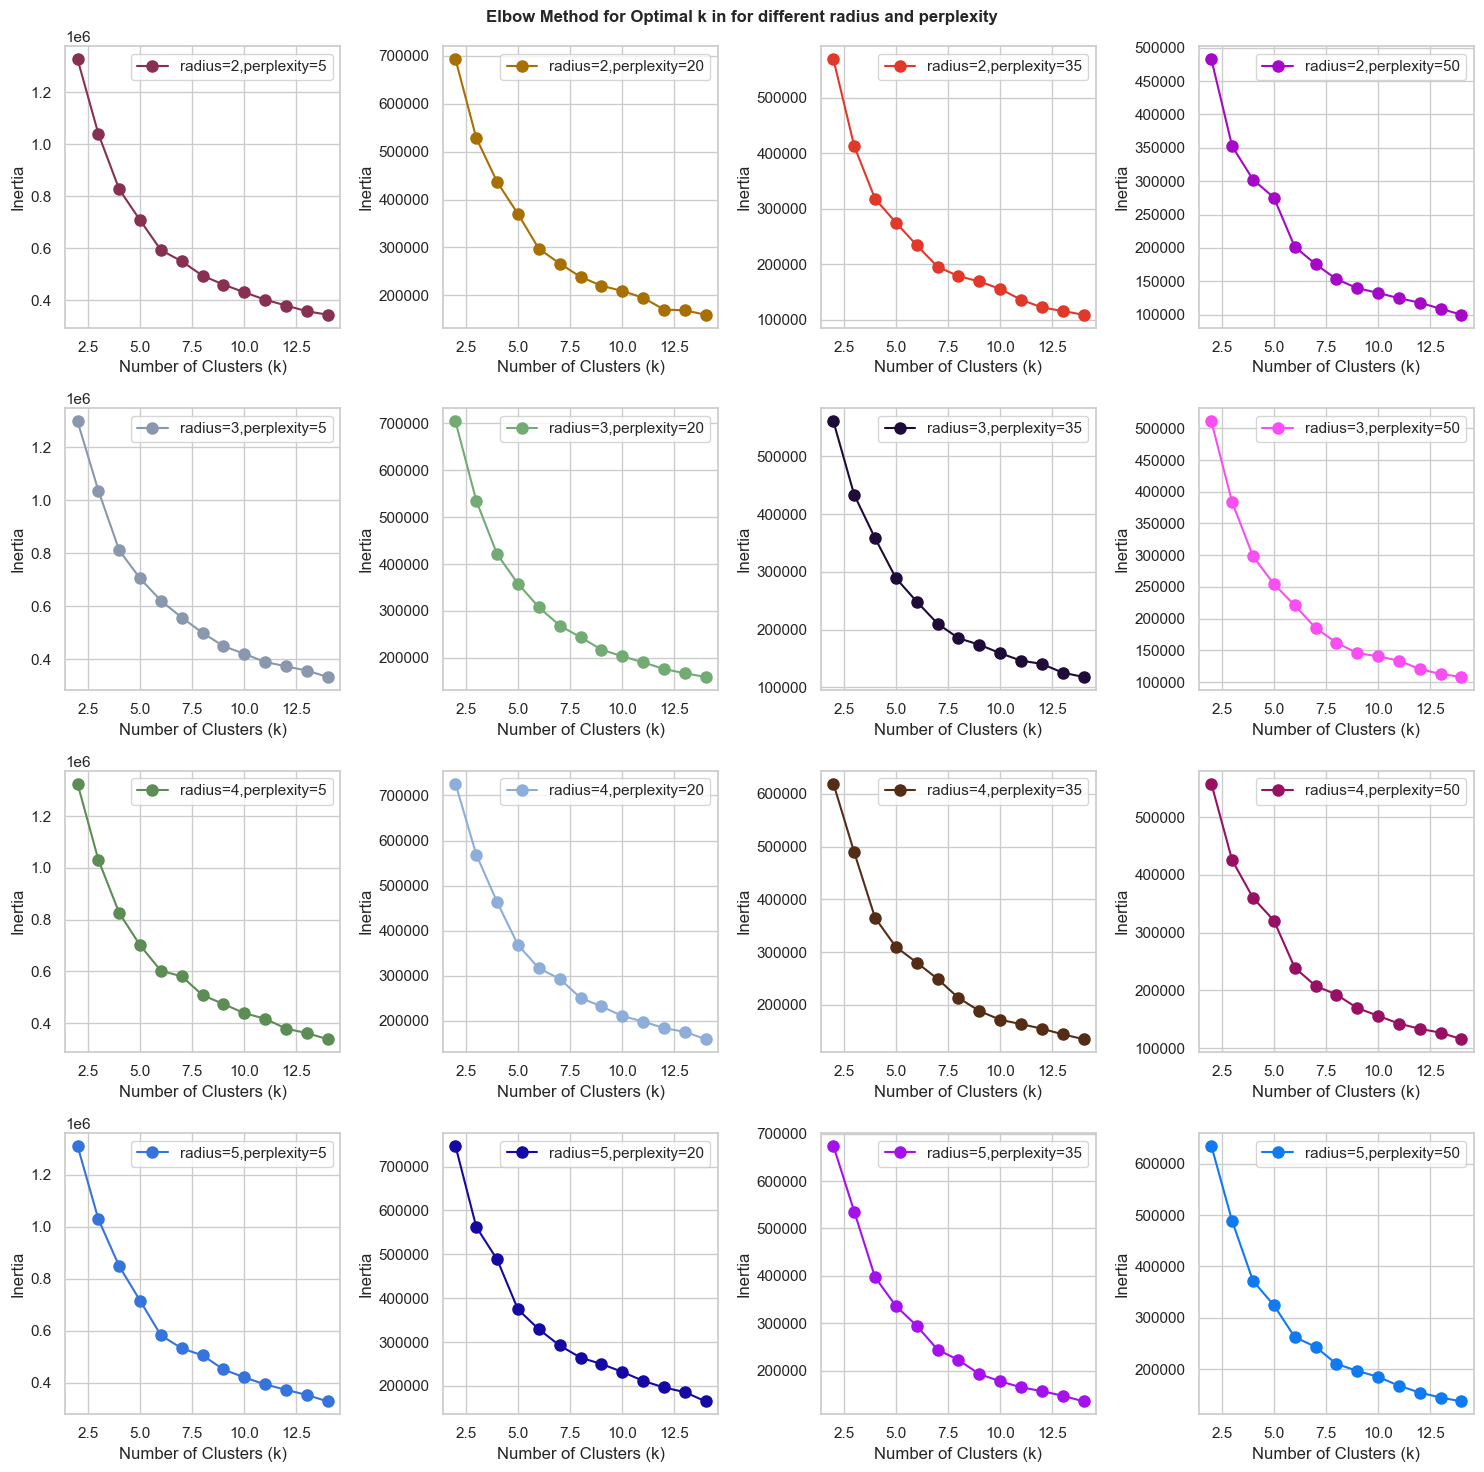

In [138]:
# Load your cleaned dataset
# Assuming the DataFrame 'hiv_data' with a column 'Ligand SMILES' is already prepared
smiles_list = hiv_data['Ligand SMILES'].unique().tolist()

radiuses = [2,3,4,5]
perplexities = [5,20,35,50]
ncols, nrows = len(perplexities), len(radiuses)
Ks = range(2, 15)
scaling = False

fgs= []
tsn_results = [[[] for _ in range(len(radiuses))] for _ in range(len(perplexities))]
KLs = np.zeros((nrows,ncols))
s_scores = [[[] for _ in range(len(radiuses))] for _ in range(len(perplexities))]

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15, 15))
pallete = sns.palettes.color_palette('deep',n_colors=nrows*ncols)

# Generate fingerprints
for idx_r, radius in enumerate(radiuses):
    print(f'doing radius {radius}')
    fingerprint_matrix = generate_fingerprints(smiles_list,radius=radius)

    if scaling:
        scaler = StandardScaler()
        fingerprint_matrix = scaler.fit_transform(fingerprint_matrix)
    fgs.append(fingerprint_matrix)

    for idx_p, perplexity in enumerate(perplexities):
        ax = axes[idx_r][idx_p]
        print(f'trying perplexity {perplexity}')
        tsn = TSNE(n_components=3, perplexity=perplexity, init='random', learning_rate='auto', random_state=0)
        tsn_result = tsn.fit_transform(fingerprint_matrix)
        tsn_results.append(tsn_result)
        tsn_results[idx_r][idx_p][:] = tsn_result
        KLs[idx_r][idx_p] = tsn.kl_divergence_
        inertia = []
        s_score = []
        for k in Ks:
        
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(tsn_result)
            inertia.append(kmeans.inertia_)
            s_score.append(silhouette_score(tsn_result,kmeans.labels_))
        s_scores[idx_r][idx_p][:] = s_score

        # Plot the Elbow curve
        ax.plot(Ks, inertia, 'o-', markersize=8, label=f'radius={radius},perplexity={perplexity}',color=np.random.rand(3,))
        ax.legend()
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel('Inertia')


plt.suptitle('Elbow Method for Optimal k in for different radius and perplexity', fontweight='bold',fontsize=12)
plt.tight_layout()
plt.show()

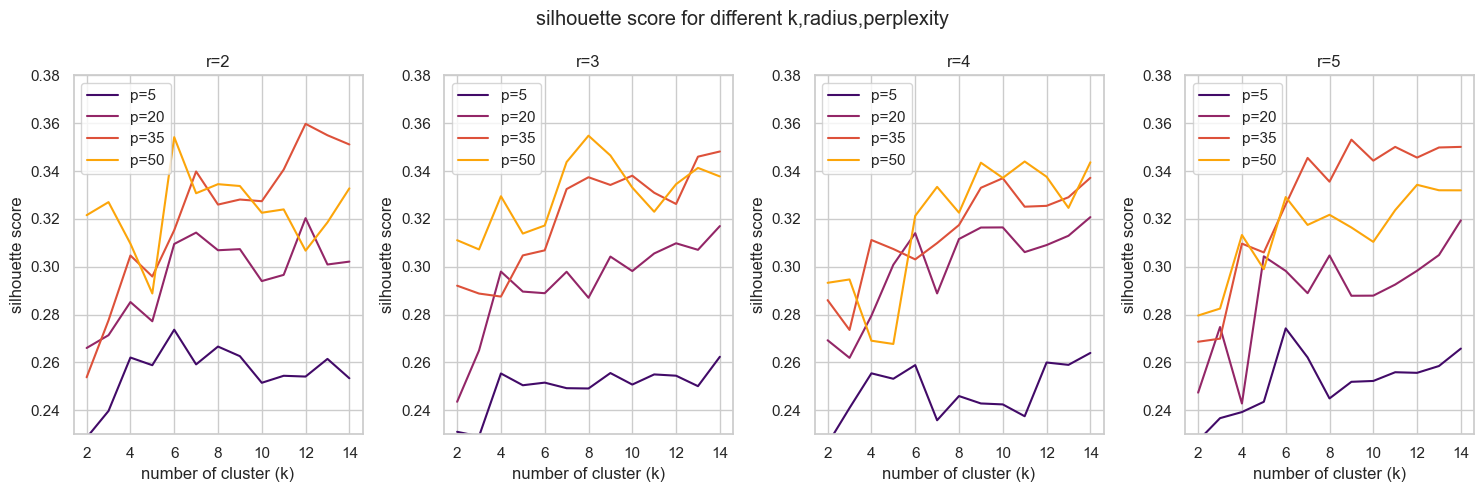

In [139]:
fig, axes = plt.subplots(nrows=1,ncols=ncols,figsize=(15,5))
axes = axes.flatten()
palette = sns.color_palette("inferno", n_colors=len(perplexities))
for idx_r, row in enumerate(s_scores):
    for idx_p, s_score in enumerate(row):
        axes[idx_r].plot(Ks,s_score,label=f'p={perplexities[idx_p]}',color=palette[idx_p])
    axes[idx_r].legend()
    axes[idx_r].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[idx_r].set_xlabel('number of cluster (k)')
    axes[idx_r].set_ylabel('silhouette score')
    axes[idx_r].set_ylim(0.23,0.38)
    axes[idx_r].set_title(f'r={radiuses[idx_r]}')

plt.suptitle('silhouette score for different k,radius,perplexity')
plt.tight_layout()
plt.show()

In [140]:
# Choose best k for each radius and perplexity based on the graphes (not always clearly defined for some) (above 12 is excessive)
best_ks = [[6,12,12,6],
           [4,9,8,8],
           [6,6,10,9],
           [6,8,12,9]]

In [ ]:
# Checks the balance of the distribution with entropy and corrects for the number of clusters (range from 0 to 1, imbalanced to perfectly balanced)
def normalized_entropy(counts):
    k = len(counts) 
    probs = counts / counts.sum()  
    raw_entropy = entropy(probs)  
    max_entropy = np.log(k) 
    return raw_entropy / max_entropy

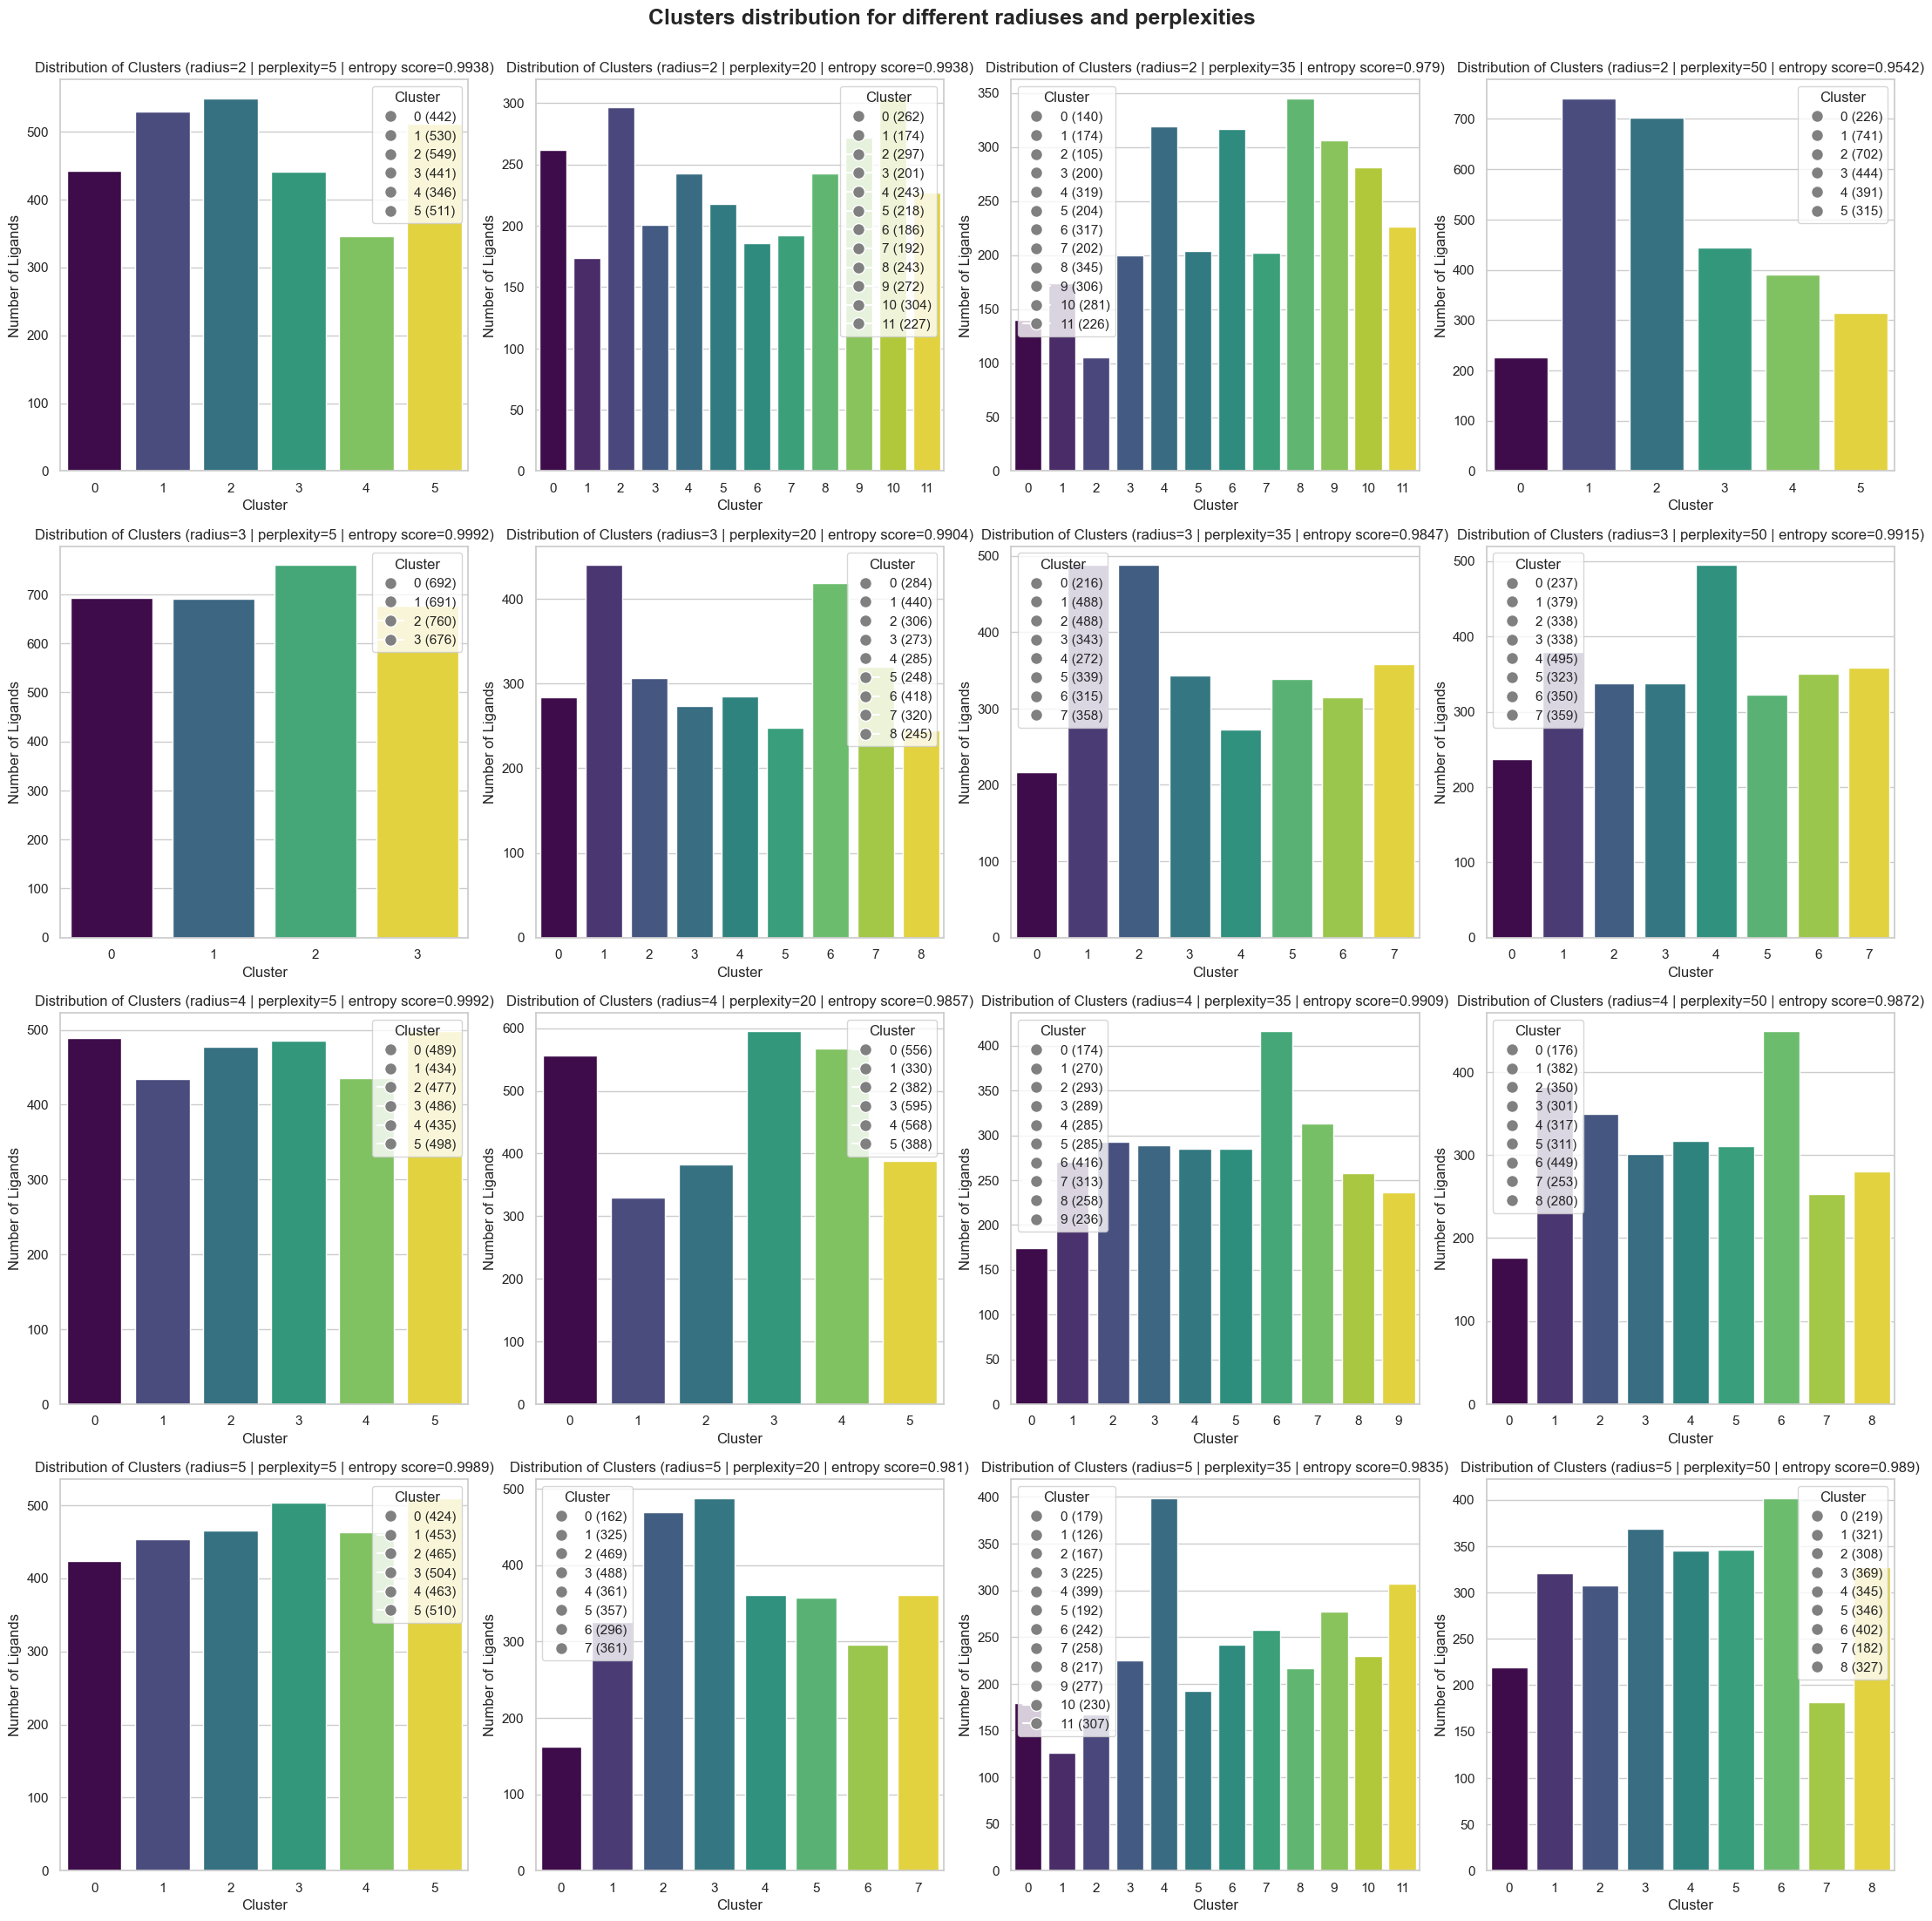

In [171]:
# Check distribution of in clusters found
fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(22, 22))

score = 0

for idx_r, radius in enumerate(radiuses):
    for idx_p, perplexity in enumerate(perplexities):
        ax=axes[idx_r][idx_p]
        kmeans = KMeans(n_clusters=best_ks[idx_r][idx_p], random_state=42)
        kmeans.fit(tsn_results[idx_r][idx_p])

        # Add cluster labels to the DataFrame
        labels = pd.DataFrame(kmeans.labels_, columns=['labels'])
        cluster_counts = labels['labels'].value_counts()
        score = round(normalized_entropy(cluster_counts), 4)

        sns.countplot(x='labels', hue='labels', data=labels, palette='viridis', ax=ax)
        ax.set_title(f'Distribution of Clusters (radius={radius} | perplexity={perplexity} | entropy score={score})')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of Ligands')

        legend_labels = [f'{cluster} ({cluster_counts.get(cluster, 0)})' for cluster in range(best_ks[idx_r][idx_p])]
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10) for _ in range(best_ks[idx_r][idx_p])]
        
        ax.legend(handles, legend_labels, title='Cluster')

plt.suptitle('Clusters distribution for different radiuses and perplexities', fontweight='bold', fontsize=18, y=1.001)
plt.tight_layout()
plt.show()

In [179]:
# Choose best index based on KL
for idx_r in range(nrows):
    for idx_p in range(ncols):
        print(f'radius: {radiuses[idx_r]} | perplexity: {perplexities[idx_p]} | KL score: {KLs[idx_r][idx_p]}')

min_index_flat = np.argmin(KLs)
min_index = np.unravel_index(min_index_flat, KLs.shape)
k = best_ks[min_index[0]][min_index[1]]

radius: 2 | perplexity: 5 | KL score: 0.5613718032836914
radius: 2 | perplexity: 20 | KL score: 0.5116504430770874
radius: 2 | perplexity: 35 | KL score: 0.5049332976341248
radius: 2 | perplexity: 50 | KL score: 0.4930573105812073
radius: 3 | perplexity: 5 | KL score: 0.5668769478797913
radius: 3 | perplexity: 20 | KL score: 0.5250749588012695
radius: 3 | perplexity: 35 | KL score: 0.5210806727409363
radius: 3 | perplexity: 50 | KL score: 0.5242923498153687
radius: 4 | perplexity: 5 | KL score: 0.5631123185157776
radius: 4 | perplexity: 20 | KL score: 0.5208603143692017
radius: 4 | perplexity: 35 | KL score: 0.531927764415741
radius: 4 | perplexity: 50 | KL score: 0.5496487617492676
radius: 5 | perplexity: 5 | KL score: 0.5546144247055054
radius: 5 | perplexity: 20 | KL score: 0.5322427153587341
radius: 5 | perplexity: 35 | KL score: 0.5545495748519897
radius: 5 | perplexity: 50 | KL score: 0.5746510028839111


In [183]:
fig = go.Figure()


    # KMeans clustering on each t-SNE result
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tsn_results[min_index[0]][min_index[1]])
TSNE_df = pd.DataFrame(tsn_results[min_index[0]][min_index[1]], columns=['TSNE1', 'TSNE2', 'TSNE3'])
TSNE_df['Cluster'] = kmeans.labels_

    # 3D scatter plot with clusters
scatter = go.Scatter3d(
    x=TSNE_df['TSNE1'],
    y=TSNE_df['TSNE2'],
    z=TSNE_df['TSNE3'],
    mode='markers',
    marker=dict(size=5, color=TSNE_df['Cluster'], colorscale='Inferno', opacity=0.7),
    name=f'Radius={radiuses[min_index[0]]}, KL={KLs[min_index[0]][min_index[1]]:.2f}'
)
fig.add_trace(scatter)

# Customize layout
fig.update_layout(
    title="PCA for Different Radii Clusters",
    scene=dict(
        xaxis_title='TSNE1',
        yaxis_title='TSNE2',
        zaxis_title='TSNE3',
        xaxis=dict(
            showgrid=True,
            gridwidth=2,  # Thicker grid lines
            gridcolor='gray'  # Change grid color to gray
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=2,  # Thicker grid lines
            gridcolor='gray'  # Change grid color to gray
        ),
        zaxis=dict(
            showgrid=True,
            gridwidth=2,  # Thicker grid lines
            gridcolor='gray'  # Change grid color to gray
        ),
    ),
    height=800, width=1200,
    template="plotly_white"
)

# Display the figure
fig.show()

In [278]:
smiles_cluster = pd.DataFrame(smiles_list)
smiles_cluster[f'Cluster'] = 0
for cluster in range(k):
    smiles_cluster[f'Cluster'] += ((TSNE_df['Cluster'] == cluster)*(cluster+1))
smiles_cluster.columns = ['Ligand SMiles', 'Cluster']
smiles_cluster.sample(10)

,Ligand SMiles,Cluster
1302,COc1ccc2c(OC\C=C/CN(C[C@@H](O)[C@H](Cc3ccccc3)...,5
2322,CC[C@H](C)[C@@H](NC(=O)[C@H]([C@H](C)O)N(C)C(=...,2
2532,Nc1cc(ccc1F)N1[C@H](CCc2ccccc2)[C@@H](O)[C@@H]...,3
894,COc1cc(CN2C[C@H](Cc3ccccc3)N(C[C@@H](O)C[C@@H]...,2
1904,COC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](...,2
934,O[C@H](CN1CCCCC=CCCCCCCC(OC1=O)c1ccccc1)[C@H](...,5
1303,COc1ccc2c(OCCCCN(C[C@@H](O)[C@H](Cc3ccccc3)NC(...,5
1843,CCc1ccc(C[C@@H]2[C@H](O)[C@@H](O)[C@@H](Cc3ccc...,3
1502,CC(C)[C@@H]1NC(=O)CNC(=O)COc2ccc(C[C@H](NC1=O)...,4
1019,CCC1(CCCC1)N(CCO)C(=O)c1ccccc1CCC(O)Cc1ccc(C)c...,4


In [279]:
#Extract molecular weight, h-bond, ... from clusters
from rdkit.Chem import Descriptors

def extract_info_smiles(data, molecular_weights, h_bond_donors, h_bond_acceptors, xlim=2000):
    for smiles in data['Ligand SMILES']:
        try:
            mol = Chem.MolFromSmiles(smiles)  # Create RDKit molecule object
            if mol:
                # Calculate properties if SMILES is valid
                molecular_weights.append(Descriptors.MolWt(mol))
                h_bond_donors.append(Descriptors.NumHDonors(mol))
                h_bond_acceptors.append(Descriptors.NumHAcceptors(mol))
            else:
                # Add None if SMILES is invalid
                molecular_weights.append(None)
                h_bond_donors.append(None)
                h_bond_acceptors.append(None)
        except Exception as e:
            # Handle invalid SMILES error by appending None
            print(f"Error processing SMILES {smiles}: {e}")
            molecular_weights.append(None)
            h_bond_donors.append(None)
            h_bond_acceptors.append(None)

    # Add properties to DataFrame
    data['Molecular Weight'] = molecular_weights
    data['H-Bond Donors'] = h_bond_donors
    data['H-Bond Acceptors'] = h_bond_acceptors

    # Drop rows with any missing values in these new columns
    data.dropna(subset=['Molecular Weight', 'H-Bond Donors', 'H-Bond Acceptors'], inplace=True)

    # Visualization (same as before)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Molecular Weight'], bins=30, color="skyblue")
    plt.title("Distribution of Molecular Weight in HIV-Targeting Compounds")
    plt.xlabel("Molecular Weight (g/mol)")
    plt.ylabel("Frequency")
    plt.xlim([0, xlim])
    plt.show()

In [1]:
molecular_weights_0 = []
h_bond_donors_0 = []
h_bond_acceptors_0 = []

extract_info_smiles(cluster_dataframes['Cluster_0'], molecular_weights_0, h_bond_donors_0, h_bond_acceptors_0, xlim=1500)

NameError: name 'extract_info_smiles' is not defined

C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Molecular Weight'] = molecular_weights
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['H-Bond Donors'] = h_bond_donors
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

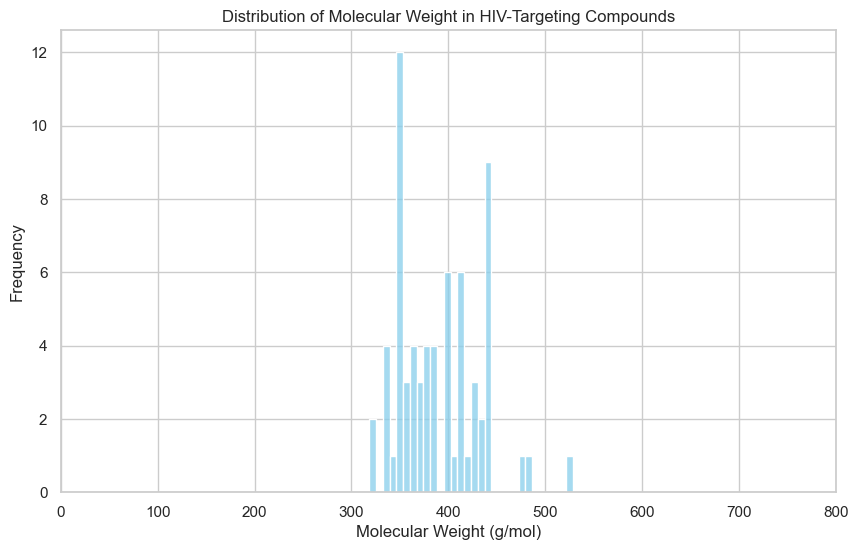

In [ ]:
molecular_weights_1 = []
h_bond_donors_1 = []
h_bond_acceptors_1 = []

extract_info_smiles(cluster_dataframes['Cluster_1'], molecular_weights_1, h_bond_donors_1, h_bond_acceptors_1, xlim=800)